# Presentation Notebook for The **Simulators**

First step to using this package will always be defining the location of the input files and data

In [1]:
from pathlib import Path
import pandas as pd

from src.power_system_simulation.graph_processing import GraphProcessor
from src.power_system_simulation import calculation_module as calc
from src.power_system_simulation import validate_power_system_simulation as validate
DATA_PATH = Path.cwd() / "tests" / "data" / "Exception_test_data"

metadata = DATA_PATH / "meta_data.json"
input_network = DATA_PATH / "input_network_data.json"
active_power_profile = DATA_PATH / "active_power_profile.parquet"
reactive_power_profile = DATA_PATH / "reactive_power_profile.parquet"
ev_active_power_profile = DATA_PATH / "ev_active_power_profile.parquet"

 validate function is called which checks and validates the data

### **Args:**

**input_network**(str) location of the input data in a string

**metadata**(str) location of the metadata in a string

**ev_active_power_profile**(str) location of the ev_active_power_profile in a string

### **Raises**
- **TimestampsDoNotMatchError** (Timestamps of active and reactive power profiles do not match.)
- **LoadIdsDoNotMatchError** (Load IDs of active and reactive power profiles do not match.)
- **IDNotFoundError** (Vertex ID present in edge_vertex_id_pairs does not exist.)
- **InputLengthDoesNotMatchError** (The amount of vertex pairs is not equal to the amount of edges.)
- **IDNotUniqueError** (vertex and edge ids are not unique.)
- **GraphNotFullyConnectedError** (Graph not fully connected)
- **GraphCycleError** (The graph contains cycles.)
- **TooManyTransformers** (This Input data contains more than one transformer)
- **TooManySources** (This Input data contains more than one source)
- **NotAllFeederIDsareValid** (not all feeders are valid lines)
- **TransformerAndFeedersNotConnected** (Feeders and transformers are not connected to the same graph)
- **TooFewEVs** (there are less EVs profiles than symloads)


In [2]:
validate.validate_power_system_simulation(input_network, metadata,ev_active_power_profile)

Next the various functions of the package include: 
- making a graph
- visualizing a graph 
- finding a downstream vertice
- finding alternative edges
- Powergrid power calculations 
- finding an optimal tap position
- EV penetration level 
- N-1 calculation

## Making a graph
- A class for processing undirected graphs.
- This class provides functionality to initialize a graph, find downstream vertices of an edge, and identify alternative edges for ensuring graph connectivity.

Attributes:
- graph: A NetworkX graph representing the processed graph.

Args:
- **vertex_ids** (List[int]): List of vertex IDs.
- **edge_ids** (List[int]): List of edge IDs.
- **edge_vertex_id_pairs** (List[Tuple[int, int]]): List of tuples - - representing vertex pairs for each edge.
- **edge_enabled** (List[bool]): List indicating whether each edge is - enabled (True) or disabled (False).
- **source_vertex_id** (int): ID of the source vertex.

Raises:
- **IDNotUniqueError**: If there are duplicate vertex or edge IDs.
- **InputLengthDoesNotMatchError**: If the length of edge_enabled does not match the input lists edge_ids.
- **IDNotFoundError**: If a vertex ID present in edge_vertex_id_pairs does not exist in vertex_ids.
- **GraphNotFullyConnectedError**: If the graph is not fully connected.
- **GraphCycleError**: If the graph contains cycles.

To demonstrate the functionality of the class, the grid can be created as follows:

In [3]:
vertex_ids = [0, 2, 4, 6, 10]
edge_ids = [1, 3, 5, 7, 8, 9]
edge_vertex_id_pairs = [(0, 2), (0, 4), (0, 6), (2, 4), (4, 6), (2, 10)]
edge_enabled = [True, True, True, False, False, True]
source_vertex_id = 10

grid = GraphProcessor(vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id)

## Visualizing a graph
Here Carmelo's graph code
Here some explaination

Now, the graph can be visualized as follows:

## Finding a downstream vertice
 Args:
- starting_edge_id (int): ID of the edge to find downstream vertices for.

Returns:
- List[int]: List of vertex IDs downstream from the specified edge.

### Working Principle:
- Verify that the edge ID exists
- Check if the edge is already disabled, which would be 
- Get the vertices of the edge
- Simulate the edge being disabled by temporarily removing it
- Find all connected components after the removal
- Restore the edge to maintain original graph state
- Determine which component contains the source vertex
- Return the nodes in the component that does not contain the source vertex


In [4]:
downstream_vertices = grid.find_downstream_vertices(1)
downstream_vertices

[0, 4, 6]

## Finding alternative edges
Args:
- disabled_edge_id (int): The ID of the edge to be disabled.

Returns:
- List[int]: A list of alternative edge IDs.

### Working principle:
- a list of ORIGINALLY disabled edges is created
- errors are checked and empty output list is initialised
- a list of UPDATED disabled edges is made with disabled_edge_id considered
- a list of edges is created: the list(zip()) functions pair each edge_id with the corresponding vertex pair and status-enables/disabled
-  a new list is made where disabled_edge_id considered (it becomes disabled)
-  the ORIGINALLY disabled edges are taken one by one (while loop). For each iteration, the edge is now ENABLED "temporarily" and a new graph is made. This graph is then checked for cyclicity and completeness. If satisfactory, the ORIGINALLY disabled index is added to the output list alt_list[]
- after iterations end, the output list is printed

[7]

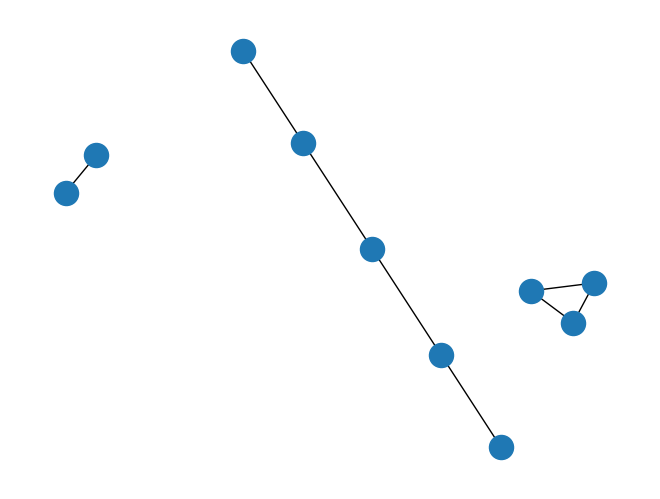

In [5]:
alternative_edges = grid.find_alternative_edges(1)
alternative_edges

# Large Powergrid
now we have seen how a small graph can be created, a large powergrid is loaded for the following sections.

In [6]:
DATA_PATH = Path('C:/Users/20212771/Downloads/big_network/input')
metadata = DATA_PATH / "meta_data.json"
input_network = DATA_PATH / "input_network_data.json"
active_power_profile = DATA_PATH / "active_power_profile.parquet"
reactive_power_profile = DATA_PATH / "reactive_power_profile.parquet"
ev_active_power_profile = DATA_PATH / "ev_active_power_profile.parquet"

## Validation

The input is once more validates to ensure that it is compatible with the data

In [7]:
validate.validate_power_system_simulation(input_network, metadata,ev_active_power_profile)

## Powergrid power calculations:
- Analyze power flow on the given power grid network using provided active and reactive power profile data.

function: 
- calculate_power_grid()

Args:
- **input_network_data** (Dict): Input network data in JSON format.
- **active_power_profile_path** (str): Path to the parquet file containing active power profile data.
- **reactive_power_profile_path** (str): Path to the parquet file containing reactive power profile data.

Returns:
- Dict: Aggregated power flow results containing voltage statistics and line loading information.

### Working Principle:
- Load input network data
- Validate input data
- Load active and reactive power profiles
- Check if timestamps and load IDs match
- Create PGM batch update dataset
- Validate batch data
- Run power flow calculations
- Aggregating voltage results
- Aggregating line loading results
- Create DataFrame for voltage results
- Create DataFrame for line results
- Return aggregated results

In [78]:
from src.power_system_simulation.calculation_module import (
    calculate_power_grid,
)

voltage_results, line_results = calculate_power_grid(
        input_network, active_power_profile, reactive_power_profile
)
voltage_results

,Max_Voltage,Max_Voltage_Node,Min_Voltage,Min_Voltage_Node
Timestamp,,,,
2025-01-01 00:00:00,1.072931,1,1.049819,0
2025-01-01 00:15:00,1.075911,1,1.050022,0
2025-01-01 00:30:00,1.069725,1,1.049603,0
2025-01-01 00:45:00,1.073244,1,1.049842,0
2025-01-01 01:00:00,1.072924,1,1.049819,0
...,...,...,...,...
2025-01-10 22:45:00,1.071457,1,1.049730,0
2025-01-10 23:00:00,1.075341,1,1.049993,0
2025-01-10 23:15:00,1.072623,1,1.049803,0


In [79]:
print("Line Results:")
line_results

Line Results:


,Total_Loss,Max_Loading,Max_Loading_Timestamp,Min_Loading,Min_Loading_Timestamp
Line_ID,,,,,
1204,214.476076,5.824780e-02,2025-11-07 09:45:00,4.447163e-03,2025-10-08 12:45:00
1205,0.736725,5.680893e-03,2025-04-07 10:30:00,4.082249e-07,2025-03-04 17:15:00
1206,219.597895,5.442560e-02,2025-11-05 23:15:00,3.731235e-03,2025-10-08 12:45:00
1207,0.898303,4.752569e-03,2025-05-29 02:30:00,4.118517e-07,2025-12-29 15:30:00
1208,202.147152,5.648105e-02,2025-11-07 09:45:00,3.791173e-03,2025-10-08 12:45:00
...,...,...,...,...,...
2006,0.032063,2.444916e-07,2025-10-02 19:45:00,2.399379e-07,2025-11-05 07:30:00
2007,0.031663,2.445316e-07,2025-10-08 17:45:00,2.401123e-07,2025-11-04 22:30:00
2008,0.037419,2.444854e-07,2025-10-02 20:15:00,2.395951e-07,2025-11-07 15:00:00


## Finding an optimal tap position

## EV penetration level 

Simulates the penetration of electric vehicles (EVs) in a power grid network and calculates
the resulting voltage and line loading profiles.

Function:
- EVpenetration()

Args:
- input_network_data (str): Path to the input network data file.
- meta_data_str (str): Path to the metadata file.
- active_power_profile_path (str): Path to the active power profile file.
- ev_active_power_profile (str): Path to the EV active power profile file.
- percentage (float): Percentage of EV penetration.
- seed (int): Random seed for reproducibility.

Returns:
tuple: A tuple containing two DataFrames:
- voltage_df: DataFrame with voltage results.
- line_df: DataFrame with line loading results.

## N-1 calculation